
Loading data: done


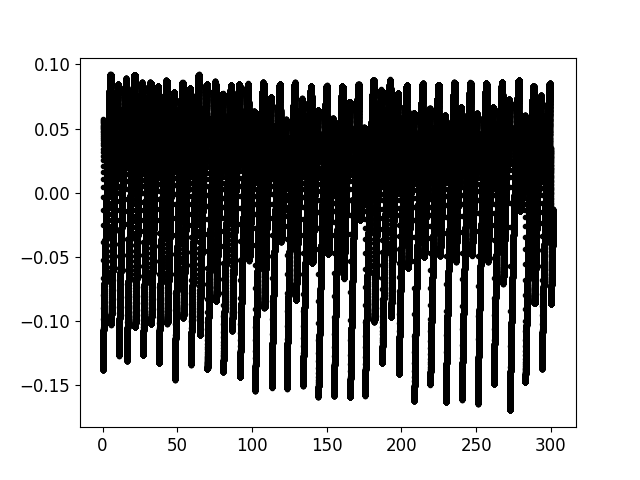

In [2]:
%matplotlib ipympl

import os
import matplotlib.pyplot as plt
import time
import numpy as np
from utils.load import load_data
from utils.load import add_noise
from utils.params import set_param

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fontsize = 12
plt.rcParams.update({'font.size': fontsize})

np.random.seed(42)

tic_begin = time.time()

dirs = {'main' : os.getcwd()}


#%% Set case study
plt.close('all')

#exp = 'b726'
#exp = 'b698'
#exp = 'i417'
exp = 'p4679'
#exp = 'p4581'
#exp = 'cascadia'
#exp = 'sim_b726'
#exp = 'sim_b698'
#exp = 'sim_i417'

params = set_param(exp)

dirs['data'] = dirs['main'] + '/' + params['dir_data']

#% Load data
print('')
print('Loading data: ', end='')
X, Y, t, dt, vl = load_data(exp, dirs, params)
print('done')

Anoise = 0.0
X = add_noise(X, Anoise, rand_seed=42)

plt.figure()
plt.plot(t, X, '.k')

In [3]:
Y.shape

#3882 time(steps) 196 patches

(301721, 4)

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the timeseries X
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X.reshape(-1, 1))


In [5]:
import torch
from torch.utils.data import TensorDataset

# Split the data into train and test sets
train_size = int(len(X_normalized) * 0.75)
train_data = X_normalized[:train_size]
test_data = X_normalized[train_size:]

# Convert the data into PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
test_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)

print(device)

In [6]:
import torch
import torch.nn as nn

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_channels = num_channels
        self.kernel_size = kernel_size
        self.dropout = dropout
        
        self.tcn = nn.Sequential(
            nn.Conv1d(input_size, num_channels, kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size, padding=(kernel_size - 1) // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, output_size, kernel_size, padding=(kernel_size - 1) // 2)
        )
    
    def forward(self, x):
        return self.tcn(x)


In [7]:
# Create an instance of the TCN model
input_size = 1  # Number of input features
output_size = 1  # Number of output features
num_channels = 64  # Number of channels in the TCN layers
kernel_size = 3  # Kernel size for the TCN layers
dropout = 0.2  # Dropout rate for the TCN layers

model = TCN(input_size, output_size, num_channels, kernel_size, dropout)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


TCN(
  (tcn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
)

In [9]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# Create data loaders for training and testing
batch_size = 64
train_loader = DataLoader(TensorDataset(train_tensor[:-1], train_tensor[1:]), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_tensor[:-1], test_tensor[1:]), batch_size=batch_size, shuffle=False)

import torch.optim as optim
import torch.nn as nn

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")
    for inputs, targets in progress_bar:
        inputs = inputs.unsqueeze(1).to(device)
        targets = targets.unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix({"Train Loss": train_loss / len(train_loader.dataset)})


Epoch 10/10, Train Loss: 0.0000: 100%|██████████| 3536/3536 [00:16<00:00, 217.84it/s, Train Loss=0.00118] 


In [10]:
def inference(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
    return np.concatenate(predictions)


In [11]:
# Generate predictions using the trained model and the test data
test_inputs = test_tensor[:-1].unsqueeze(1).to(device)
test_outputs = model(test_inputs)
predictions = test_outputs.detach().cpu().numpy()

# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
test_data = scaler.inverse_transform(test_data.reshape(-1, 1))


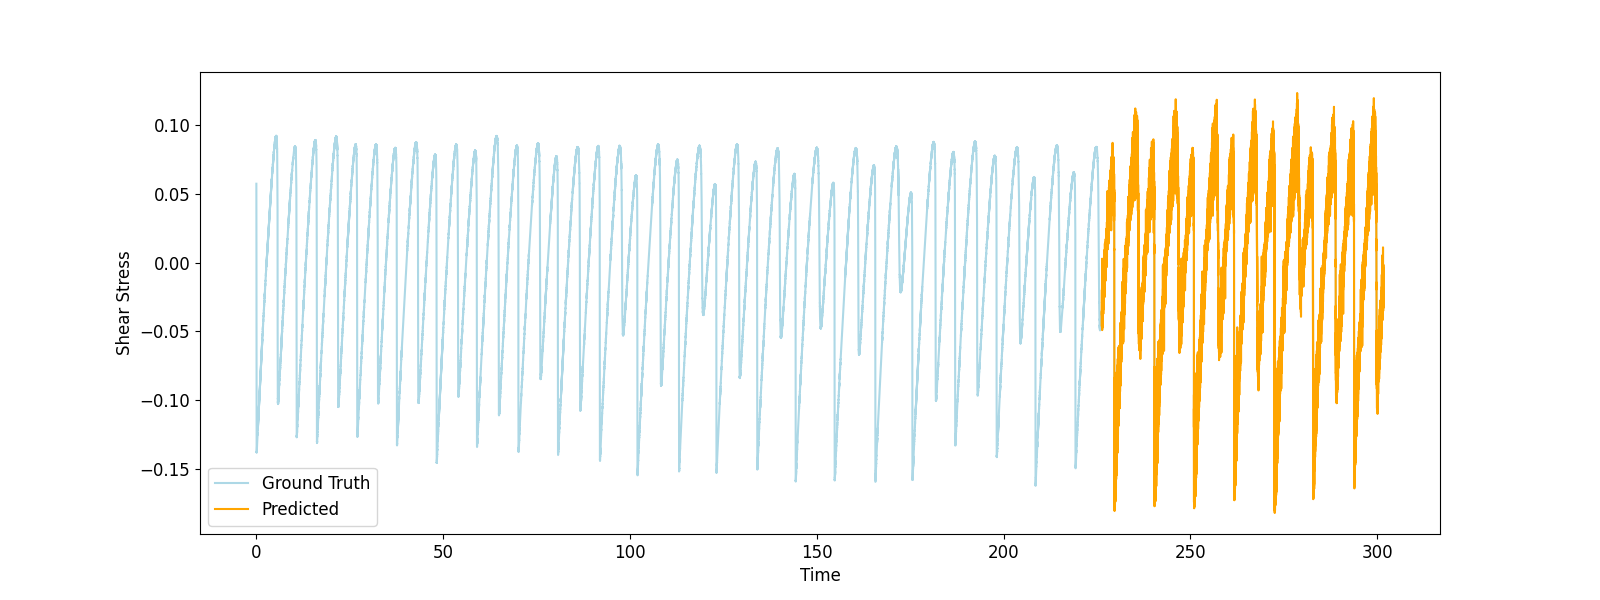

In [12]:
# Line plot of all the ground truth data in light blue
plt.figure(figsize=(16, 6))
plt.plot(t, X, color='lightblue', label='Ground Truth')

# Overlay the predicted data on top in orange
plt.plot(t[train_size+1:], predictions, color='orange', label='Predicted')

plt.xlabel('Time')
plt.ylabel('Shear Stress')
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import mean_squared_error, r2_score

# Ensure the data sizes are the same
if len(predictions) != len(test_data):
    min_len = min(len(predictions), len(test_data))
    predictions = predictions[:min_len]
    test_data = test_data[:min_len]

# Calculate the RMSE
rmse = mean_squared_error(test_data, predictions, squared=False)

# Calculate the R-squared
r2 = r2_score(test_data, predictions)

print("RMSE:", rmse)
print("R-squared:", r2)



RMSE: 0.009041155176329953
R-squared: 0.980121517969137
